In [11]:
import os
import librosa

base_dir = r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset"

sub_dirs = [r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset\Real\Real", r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset\Fake\Fake"]

audio_data = []

for sub_dir in sub_dirs:
    folder_path = os.path.join(base_dir, sub_dir)
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    if not files:
        print(f"No .wav files found in {folder_path}")
        continue  
    folder_path = os.path.join(base_dir, sub_dir)
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):  # Ensure only .wav files are processed
            file_path = os.path.join(folder_path, file_name)
            
            audio, sr = librosa.load(file_path, sr=None)  # sr=None preserves original sampling rate
            
            label = 0 if sub_dir == "real" else 1
            audio_data.append((audio, sr, label))

print(f"Number of audio files loaded: {len(audio_data)}")
print(f"First file: Audio Length={len(audio_data[0][0])}, Sampling Rate={audio_data[0][1]}, Label={audio_data[0][2]}")


C:\Users\Aditya Koul\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Number of audio files loaded: 42
First file: Audio Length=25084080, Sampling Rate=44100, Label=1


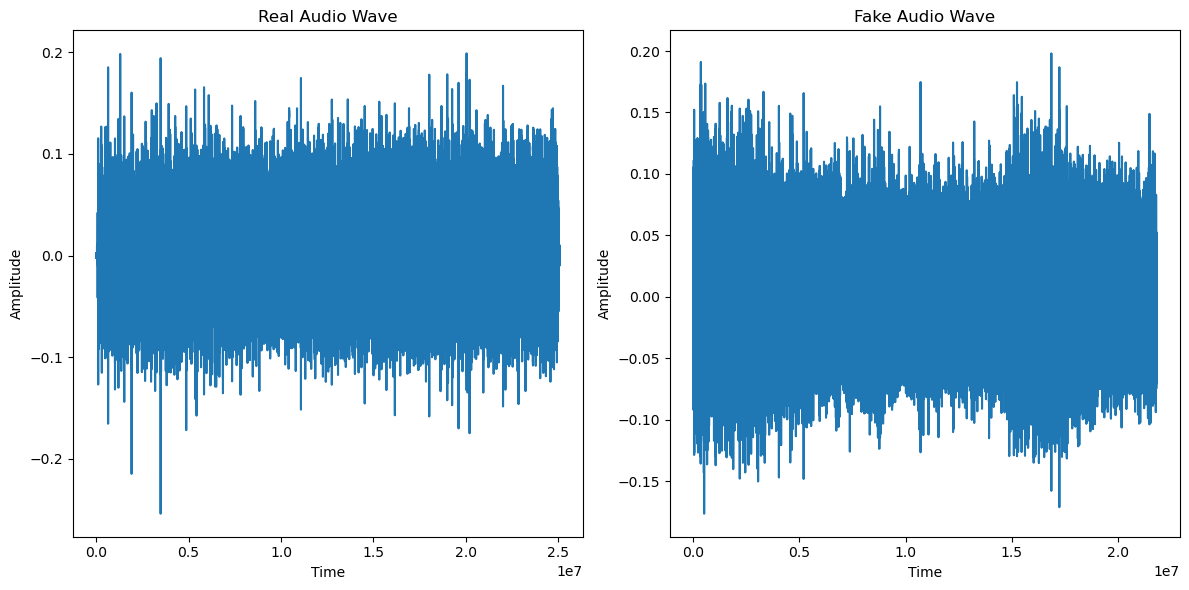

In [15]:
import matplotlib.pyplot as plt
import numpy as np
real_file_path = r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset\Real\Real\Recording (1).wav"
fake_file_path = r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset\Fake\Fake\Recording (1).wav"
real_audio, real_sr = librosa.load(real_file_path, sr=None)
fake_audio, fake_sr = librosa.load(fake_file_path, sr=None)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(real_audio)
plt.title("Real Audio Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.plot(fake_audio)
plt.title("Fake Audio Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

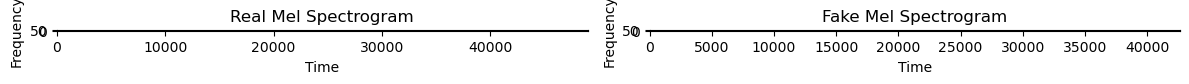

In [16]:


def extract_melspectrogram(audio, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db


real_mel = extract_melspectrogram(real_audio, real_sr)
fake_mel = extract_melspectrogram(fake_audio, fake_sr)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(real_mel, origin='lower', cmap='inferno')
plt.title("Real Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.imshow(fake_mel, origin='lower', cmap='inferno')
plt.title("Fake Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import librosa
import os
import glob

def extract_melspectrogram(audio, sr, n_mels=128):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]

        audio, sr = librosa.load(audio_path, sr=None)
        mel_spectrogram = extract_melspectrogram(audio, sr)

        # Fix length to 400 (pad or truncate along time axis)
        max_length = 400
        if mel_spectrogram.shape[1] < max_length:
            pad_width = max_length - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :max_length]

        mel_tensor = torch.tensor(mel_spectrogram).unsqueeze(0).float()
        return mel_tensor, torch.tensor(label)

class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.AdaptiveAvgPool2d((5, 5))  # Ensures output size is 5x5
        self.fc1 = nn.Linear(128 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

real_audio_folder = r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset\Real\Real"
fake_audio_folder = r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\dataset\Fake\Real"

real_audio_paths = glob.glob(os.path.join(real_audio_folder, "*.wav"))
fake_audio_paths = glob.glob(os.path.join(fake_audio_folder, "*.wav"))

audio_paths = real_audio_paths + fake_audio_paths
labels = [0]*len(real_audio_paths) + [1]*len(fake_audio_paths)

assert len(audio_paths) > 0, "No audio files found. Check folder paths or file extensions."

full_dataset = AudioDataset(audio_paths, labels)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = AudioClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Loss: 0.3518
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000
Test Accuracy: 100.00%



📊 Evaluation Metrics:
✅ Accuracy : 100.00%
✅ Precision: 0.0000
✅ Recall   : 0.0000
✅ F1-Score : 0.0000

📝 Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00         5
        Fake       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00         5
   macro avg       0.50      0.50      0.50         5
weighted avg       1.00      1.00      1.00         5



C:\Users\Aditya Koul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aditya Koul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aditya Koul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


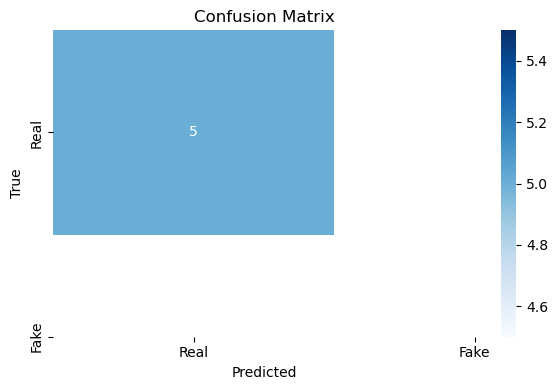

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print("\n Evaluation Metrics:")
print(f" Accuracy : {accuracy * 100:.2f}%")
print(f" Precision: {precision:.4f}")
print(f" Recall   : {recall:.4f}")
print(f" F1-Score : {f1:.4f}")

print("\n Classification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1], target_names=['Real', 'Fake'], zero_division=0))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [35]:
print("Total audio files:", len(audio_paths))
print("Real audio files :", len(real_audio_paths))
print("Fake audio files :", len(fake_audio_paths))


Total audio files: 21
Real audio files : 21
Fake audio files : 0


IT GETS A BIT OBVIOUS THAT DUE TO LESS AMOUNT OF TRAINING DATA OUR MODEL SEEMS TO HAVE OVERFIT.

So lets give it an extra path link to predict and get some ideas :


📂 Processing: jjlreal.wav


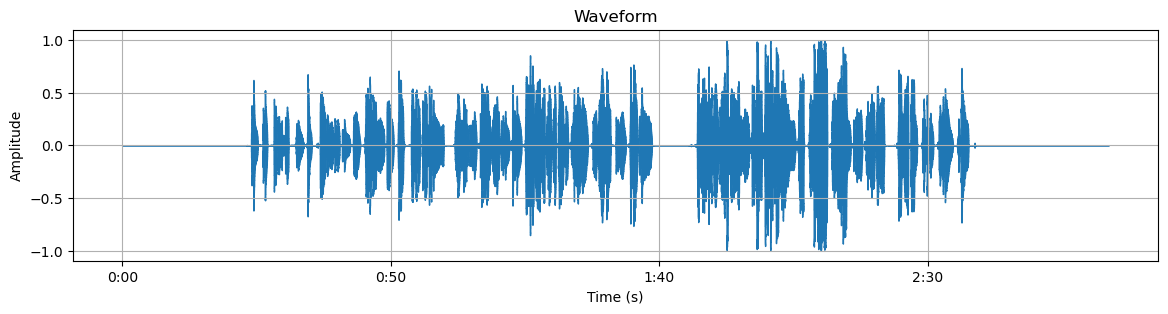

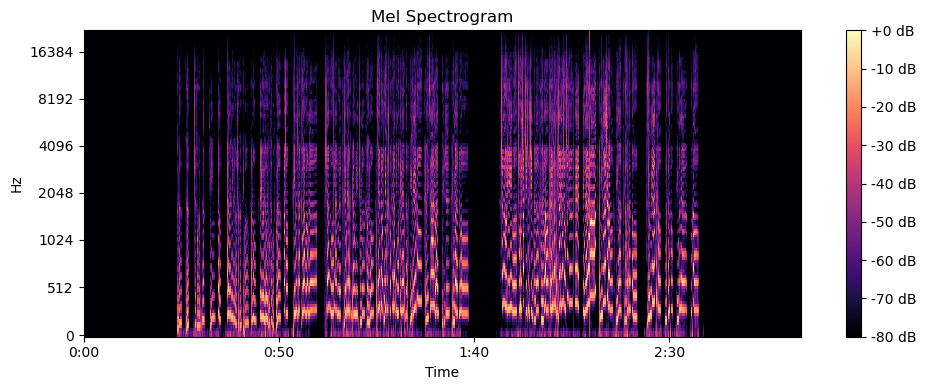

 Prediction: Real (100.00% confidence)

📂 Processing: Nothings Gonna Change My Love For You Lyrics - Justin Bieber (AI Cover).wav


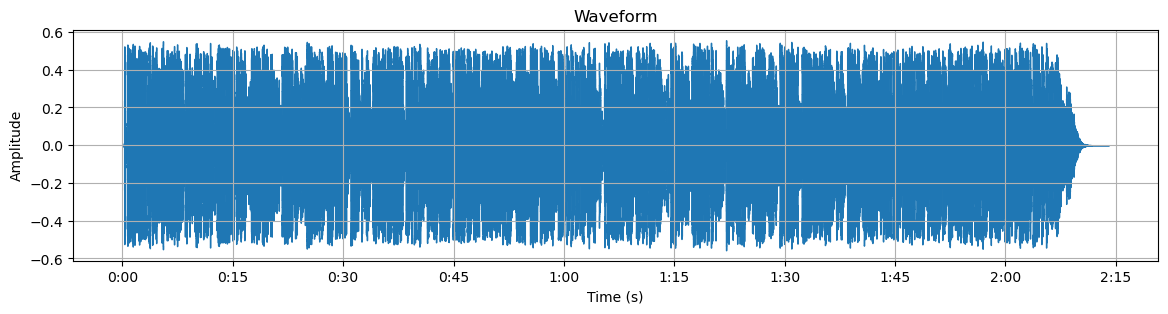

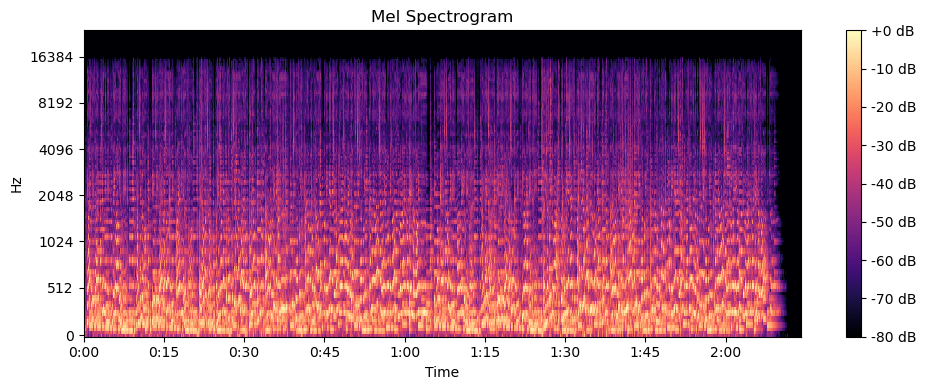

 Prediction: Real (100.00% confidence)


In [37]:
def visualize_and_predict(model, audio_paths):
    model.eval()
    for path in audio_paths:
        print(f"\n Processing: {os.path.basename(path)}")
        audio, sr = librosa.load(path, sr=None)
        plt.figure(figsize=(14, 3))
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

     
        mel = extract_melspectrogram(audio, sr)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel, sr=sr, x_axis='time', y_axis='mel')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

        mel_tensor = torch.tensor(mel).unsqueeze(0).unsqueeze(0).float()
        with torch.no_grad():
            output = model(mel_tensor)
            _, pred = torch.max(output, 1)
            label = "Real" if pred.item() == 0 else "Fake"
            confidence = torch.softmax(output, dim=1)[0][pred.item()].item()
            print(f" Prediction: {label} ({confidence*100:.2f}% confidence)")

test_files = [
    r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\extra testing audio\jjlreal.wav",
    r"C:\Users\Aditya Koul\OneDrive\Desktop\tasked\extra testing audio\Nothings Gonna Change My Love For You Lyrics - Justin Bieber (AI Cover).wav"
]

visualize_and_predict(model, test_files)

THOUGH I TOOK MUSIC FOR MY EXPERIMENTATION TESTING, IT HAS NOT BEEN ABLE TO PREDICT THE ANSWER CORRECTLY IN THE AI COVER PART.
